<a href="https://colab.research.google.com/github/PhDNoe/Sistemas_de_Inferencia_difusos/blob/main/Sistema_FIS_Sugeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![separador](https://i.imgur.com/4gX5WFr.png)
# Ejemplos de sistemas de inferencia difusos Sugeno en Python

Vamos a utilizar:
*  la librería scikit-fuzzy 
* un algoritmo de clustering sustractivo provisto por Daniel Albornoz

![separador](https://i.imgur.com/4gX5WFr.png)

### Notebook de Noe 👻👻





Importamos todas las librerias necesarias (y creo que algunas mas por costumbre)

![separador](https://i.imgur.com/4gX5WFr.png)

In [1]:
# imports
!pip install scikit-fuzzy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.optimize import least_squares

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894086 sha256=ffa0a54c3d3d8dbe71383028fa545634987d4689ba78c72be0e37f1c54d76b1d
  Stored in directory: /root/.cache/pip/wheels/32/2c/a1/a90a7d7dd8448ec029f298a61f3490275e99b17aa348be675c
Successfully built scikit-fuzzy


In [ ]:
#%reset  # para resetear todas las variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


![separador](https://i.imgur.com/4gX5WFr.png)

## Ejemplo 1) Fittear una curva de un diodo utilizando Sugeno

Generamos una curva de diodo para poder trabajar

![separador](https://i.imgur.com/4gX5WFr.png)





In [13]:
# Genero la curva de un diodo ideal
IS = 2.7e-9; # corriente de cortocircuito
q = 1.6e-19; # carga del electron
k = 1.38e-23; # constante de boltzman
T = 273+25 # Temperatura ambiente en grados kelvin
n = 1.88 # Factor de idealidad --> En diodo de Silicio n=2  , en diodo de Germanio usar n=1
VT = k*T/(q) # tension termica
# Genero rango para tensiones de diodo
VD1 = np.arange(0,0.76,0.01)
VD2 = np.arange(0.75,0.9,0.001)

print("VD1.shape",VD1.shape)
print("VD2.shape",VD2.shape)

VD = np.concatenate((VD1,VD2),axis=0) 

print(VD.shape)

# Obtengo Corriente de Diodo
ID=IS*(np.exp(VD/(n*VT))-1); # Rango de interes


I_norm=(ID-np.min(ID))/(np.max(ID)-np.min(ID))

X = (I_norm, VD)
X = np.array(X).transpose()



VD1.shape (76,)
VD2.shape (151,)
(227,)


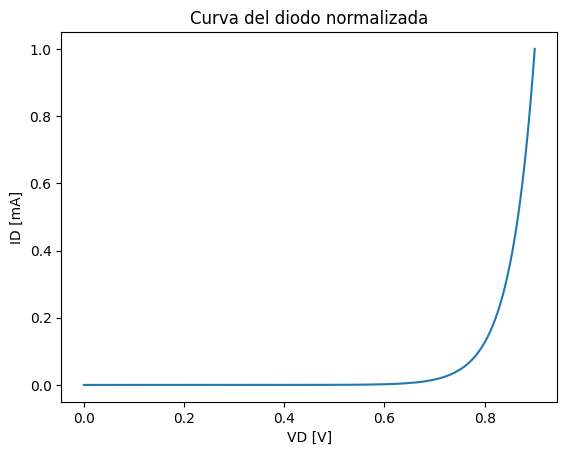

In [17]:
plt.plot(VD, I_norm)
plt.title("Curva del diodo normalizada")
plt.xlabel("VD [V]")
plt.ylabel("ID [mA]")
plt.show()

![separador](https://i.imgur.com/4gX5WFr.png)

## Clustering sustractivo

### Código de : Ing. Daniel Albornoz

![separador](https://i.imgur.com/4gX5WFr.png)

In [144]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Ra radio interno, Rb radio externo
def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

![separador](https://i.imgur.com/4gX5WFr.png)
### FIS sugeno
### Codeado por Noe 👻👻

![separador](https://i.imgur.com/4gX5WFr.png)

In [172]:
class Sugeno:
    def __init__(self, data, cluster_alg="K", sigma_mf = 0.1, K=6, Ra=0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
        self.cluster_alg = cluster_alg
        self.K = K
        self.Ra = Ra
        self.Rb = Rb
        self.AcceptRatio=AcceptRatio
        self.RejectRatio=RejectRatio
        self.X = data
        self.fitted = False
        self.sigma_mf = sigma_mf

    def fit_clusters(self):
        """
        Entrena un modelo de clustering.
        
        Opciones:
        - KMeans si cluster_alg = "K"
        - Clustering sustractivo otherwise

        """
        if self.cluster_alg =="K":
            KM = KMeans(n_clusters=self.K, init= 'k-means++', random_state=0, max_iter=400, n_init=10).fit(self.X)
            # me quedo con los labels y los centros
            self.labels = KM.labels_
            self.centers = KM.cluster_centers_
            self.fitted = True
        else:
            self.labels, self.centers = subclust2(self.X, Ra=self.Ra, Rb=self.Rb, AcceptRatio=self.AcceptRatio, RejectRatio=self.RejectRatio)
            self.fitted = True
            # subclust2(X, 0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1)

    def get_centers(self):
        """
        Retorna los centros de cluster o None si no se ha entrenado
        """
        if self.fitted:
            return self.centers
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_labels(self):
        """
        Retorna los labels para todos los datos
        o None si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_n_centers(self):
        """
        Retorna la cantidad de centros de cluster, o cero si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return []

    def plot_original_color_by_cluster(self):
        """
        Plotea los datos originales, coloreados por los centros de cluster

        """
        n = self.get_n_centers()
        # print(n)
        if len(n)!=0:
            labels = self.get_labels()
            options_col = np.linspace(0, 1, len(n))
            label_color = [options_col[x] for x in labels]


            plt.figure(figsize=(8,8))
            plt.scatter(self.X[:,1], self.X[:,0], c=label_color)
            plt.title("Datos coloreados con los centros hallados con algoritmo de clustering")

    def get_medias(self):
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

        return medias


    def plot_gaussians(self):
        # me quedo con los centros en la variable independiente (eje x o de tensiones)
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

            # Ploteo con todas las gaussiandas

            
            x1 = self.X[:,1]
            y1 = self.X[:,0]

            y_t = []
            for med in medias:
                y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) 
            
            self.y_t = y_t
            
            plt.figure(figsize=(8,8))
            plt.plot(x1, y1, 'r', linewidth=2, marker="o")
            for y in y_t:
                plt.plot(x1, y)
            plt.title("Datos con las gaussianas generadas por clustering")

        else:
            print("No es posible plotear porque no se ha inicializado un modelo de cluster")


    def get_sugeno_model_and_plot(self):
        
        x1 = self.X[:,1]
        y1 = self.X[:,0]
        medias = self.get_medias()


        y_t = []

        # El ancho de las gaussianas (desv, es un parametro importante)
        for med in medias:
            y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) #ultimo era 0.35

        def y(theta, t):
            # salidas lineales todas
            mf = []
            funx = []
            for i in range(len(theta)//2):
                mf.append(fuzz.interp_membership(x1, y_t[i], t))
                funx.append(theta[2*i] * t + theta[2*i+1])
            mf = np.array(mf)
            funx = np.array(funx)
            num =   0
            den = 0
            for i in range(len(theta)//2):
                num += mf[i]*funx[i]
                den += mf[i]
            try :
                resultado =  num/den
            except:
                resultado = None
                print("Division por cero")
            return resultado

        ts = x1
        ys =y1

        def fun(theta):
            return y(theta, ts) - ys


        theta0= [0.1, 0.2]*30
        
        n2 = 2*len(medias)
        res1 = least_squares(fun, theta0[:n2])


        # member lineal
        mse1 = (res1.fun ** 2).mean()
        # print("parametros obtenidos mediante least Squares:\n", res1.x)
        # print("error cuadratico medio:\n", mse1)




        # ploteo curva obtenida vs datos originales
        y_pred= y(res1.x, x1)

        plt.figure(figsize=(8,8))
        plt.plot(x1, y1, '.r')
        plt.plot(x1, y_pred, 'b')
        if self.cluster_alg=="K":
            str1 = "K means"
        else:
            str1 = "Clustering sustractivo"
        str2 = f"{self.centers.shape[0]} reglas"
        plt.title("Resultado final, curva generada mediante sugeno.\nAlgoritmo de cluster =  "+str1+". "+str2)

In [186]:

my_sug = Sugeno(X, cluster_alg="S", K=7, Ra=0.2)
my_sug.fit_clusters()

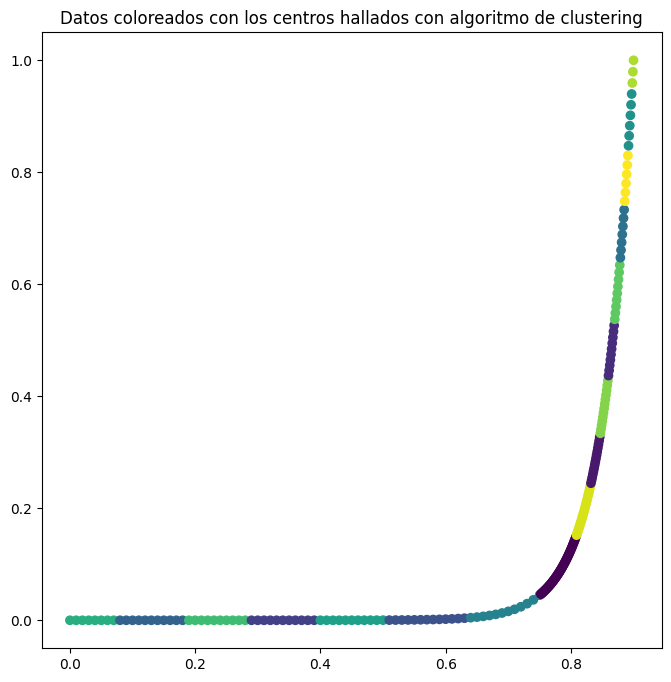

In [187]:
my_sug.plot_original_color_by_cluster()

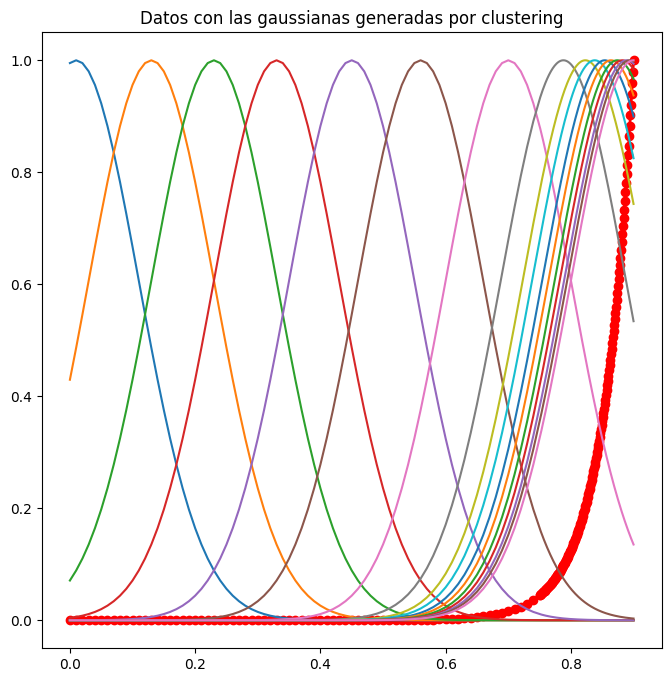

In [188]:
my_sug.plot_gaussians()

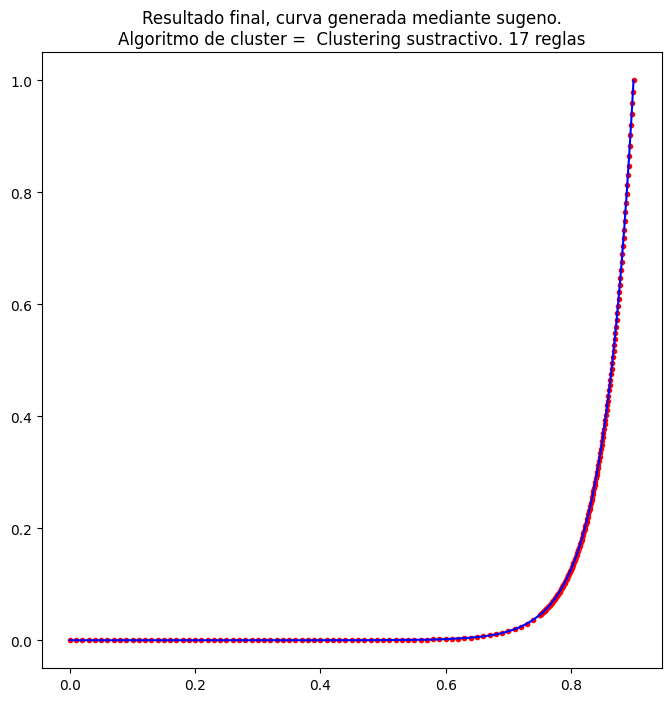

In [189]:
my_sug.get_sugeno_model_and_plot()

![separador](https://i.imgur.com/4gX5WFr.png)
## Paso a paso (es lo mismo que esta en la clase Sugeno, pero paso a paso)

---

1º Creamos la curva del diodo

![separador](https://i.imgur.com/4gX5WFr.png)

In [68]:
# Genero la curva de un diodo ideal
IS = 2.7e-9; # corriente de cortocircuito
q = 1.6e-19; # carga del electron
k = 1.38e-23; # constante de boltzman
T = 273+25 # Temperatura ambiente en grados kelvin
n = 1.88 # Factor de idealidad --> En diodo de Silicio n=2  , en diodo de Germanio usar n=1
VT = k*T/(q) # tension termica
# Genero rango para tensiones de diodo
VD1 = np.arange(0,0.75,0.01)
VD2 = np.arange(0.75,0.9,0.001)

print("VD1.shape",VD1.shape)
print("VD2.shape",VD2.shape)

VD = np.concatenate((VD1,VD2),axis=0) 

print(VD.shape)

# Obtengo Corriente de Diodo
ID=IS*(np.exp(VD/(n*VT))-1); # Rango de interes

VD1.shape (75,)
VD2.shape (151,)
(226,)


---

Ploteamos la curva del diodo

---

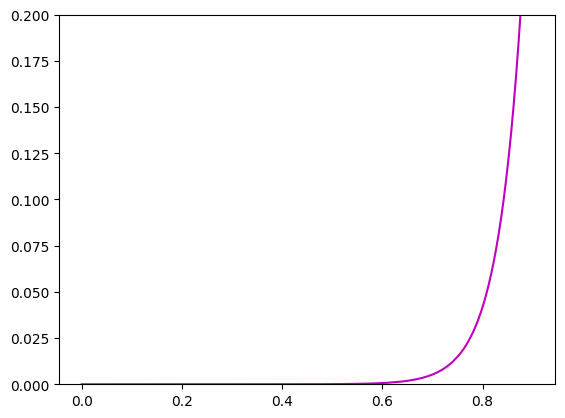

In [69]:
plt.plot(VD, ID, 'm')
plt.ylim(0,200e-3)
plt.show()

---
Utilizamos un metodo de cluster para obtener los centros de las gaussianas

---

Opcion 1: K-Means

Porque se me ocurrió, generé n centros de cluster Con lo cual el problema quedará de la siguiente manera

> Si $V_d$ es $m_{f1}$ --> $I_{D1} = a_1 \; V_d + b_1$ <br>
Si $V_d$ es $m_{f2}$ --> $I_{D2} = a_2 \; V_d + b_2$<br>
Si $V_d$ es $m_{f3}$ --> $I_{D3} = a_3 \; V_d + b_3$<br>
Si $V_d$ es $m_{f4}$ --> $I_{D4} = a_4 \; V_d + b_4$<br>

$ID_{tot} = \frac{m_{f1}  \; I_{D1} + m_{f2} \; I_{D2} + m_{f3} \; I_{D3} + m_{f4} \; I_{D4} }{ m_{f1} + m_{f2} + m_{f3} + m_{f3} }$

---

centros bidimensionales [[9.00919244e-02 7.77410959e-01]
 [5.27356771e-01 8.68500000e-01]
 [1.69144426e-05 3.30000000e-01]
 [8.35404220e-01 8.91000000e-01]
 [2.73212548e-01 8.36000000e-01]
 [2.33207984e-03 5.65000000e-01]
 [1.43112942e-07 1.05000000e-01]]
centros de variable independiente [0.105      0.33       0.565      0.77741096 0.836      0.8685
 0.891     ]


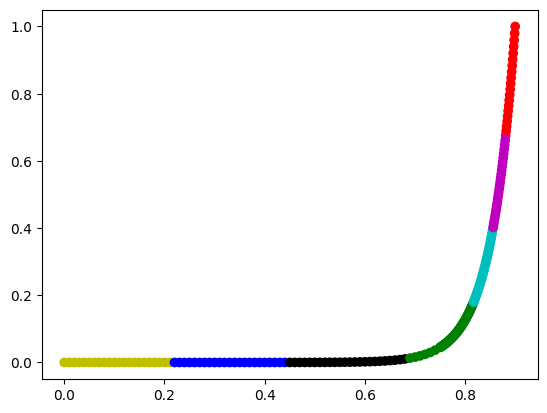

In [71]:
I_norm=(ID-np.min(ID))/(np.max(ID)-np.min(ID))

X = (I_norm, VD)
X = np.array(X).transpose()

# genero K centros de cluster con Kmeans
# TODO - implementar clustering sustractivo

K = 7
# Kmeans
KM4 = KMeans(n_clusters=K, init= 'k-means++', random_state=0, max_iter=400, n_init=10).fit(X)


# me quedo con los labels y los centros
labels4 = KM4.labels_
centers4 = KM4.cluster_centers_

# muestro los datos coloreados con los centros de cluster
label_color_map = {0 : 'g',
                   1 : 'm',
                   2 : 'b',
                   3 : 'r',
                   4 : 'c',
                   5 : 'k',
                   6 : 'y',
                   7: 'hotpink'}

label_color_kmeans = [label_color_map[x] for x in labels4]
label_color_gmm = [label_color_map[x] for x in labels4]
plt.scatter(VD, I_norm, color=label_color_kmeans)

# me quedo con los centros en la variable independiente (eje x o de tensiones)
medias4 = []
for cx, cy in centers4:
    medias4.append(cy)
medias4 = np.array(medias4)
medias4.sort()

print("centros bidimensionales", centers4)
print("centros de variable independiente", medias4)

---
Ploteo la curva del diodo junto con las gaussianas

---

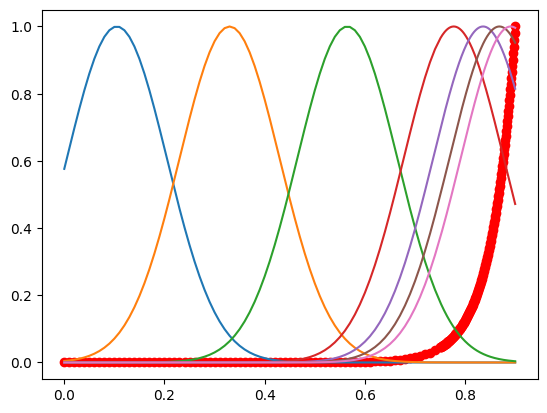

In [72]:
# x1 = np.arange(0, 0.9, 0.01)
x1 = VD

y_t = []
for med in medias4:
    y_t.append(fuzz.gaussmf(x1, med, 0.1))


plt.plot(VD, I_norm, 'r', linewidth=2, marker="o")
for y in y_t:
    plt.plot(x1, y)


---

Defino las funciones para trabajar con el optimizador (Least Squares)

---

In [73]:
def y(theta, t):
    # salidas lineales todas
    mf = []
    funx = []
    for i in range(len(theta)//2):
        mf.append(fuzz.interp_membership(VD, y_t[i], t))
        funx.append(theta[2*i] * t + theta[2*i+1])
    mf = np.array(mf)
    funx = np.array(funx)
    num =   0
    den = 0
    for i in range(len(theta)//2):
        num += mf[i]*funx[i]
        den += mf[i]
    try :
        resultado =  num/den
    except:
        resultado = None
        print("Division por cero")
    return resultado

ts = VD
ys = I_norm


def fun(theta):
    return y(theta, ts) - ys

a1 = 0.1; a2 = 0.2; a3 = 0.1; a4 = 0.2 
b1 = 0.1; b2 = 0.2 ; b3 = 0.2; b4 = 0.4
# theta0 = [a1, b1, a2, b2, a3, b3, a4, b4]
theta0 = [a1, b1, a2, b2, a1, b1, a2, b2,a1, b1, a2, b2] 
n2 = 2*len(medias4)
res1 = least_squares(fun, theta0[:n2])

---

Finalmente muestro los resultados

---

parametros obtenidos mediante least Squares:
 [ 2.48421695e-02 -5.43913888e-04  1.18427972e-01 -3.08906584e-02
  1.37189913e+00 -5.57560260e-01  4.61585769e+02 -9.48129686e+01
  4.80666754e+03 -2.29519293e+03  2.79460483e+03 -4.41061370e+03]
error cuadratico medio:
 5.544463391433489e-07


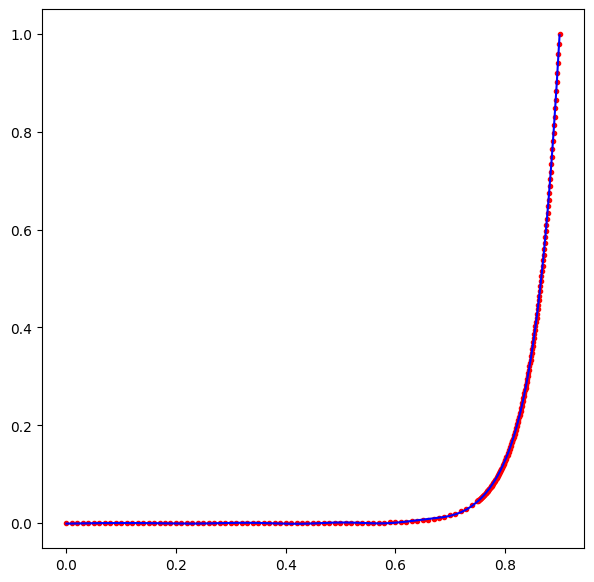

In [74]:
# member lineal
mse1 = (res1.fun ** 2).mean()
print("parametros obtenidos mediante least Squares:\n", res1.x)
print("error cuadratico medio:\n", mse1)



# ploteo curva obtenida vs datos originales
ID_pred = y(res1.x, VD)

plt.figure(figsize=(7,7))
plt.plot(VD, I_norm, '.r')
plt.plot(VD, ID_pred, 'b')

---
### Ej. 2 guia sugeno

---

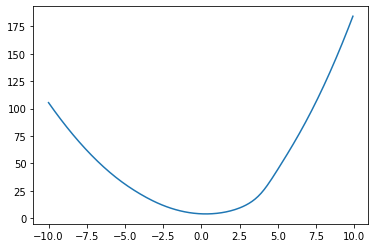

In [ ]:
y_t = []

x1 = np.arange(-10,10,0.1)

y_t.append(fuzz.gbellmf(x1, 6,4,-10))
y_t.append(fuzz.gbellmf(x1, 4,4,0 ))
y_t.append(fuzz.gbellmf(x1, 6,4,10 ))

y_small = x1**2 + 0.1*x1+6.4
y_medium = x1**2-0.5*x1+4
y_big = 1.8*x1**2+x1-2

funx = [y_small, y_medium, y_big]


mf = []
mf.append(fuzz.interp_membership(x1, y_t[0], x1))
mf.append(fuzz.interp_membership(x1, y_t[1], x1))
mf.append(fuzz.interp_membership(x1, y_t[2], x1))

num = mf[0]*funx[0] + mf[1]*funx[1]+mf[2]*funx[2]
den = mf[0]+mf[1]+mf[2]

y = num/den

plt.plot(x1, y)





---
### VDA
---

In [164]:
y = np.array([421,424,431,440,455,474,495,518,542,565,
    587,608,627,645,659,669,675,679,678,674,
    669,662,652,644,635,624,615,606,597,589,
    582,575,570,566,562,560,559,558,560,560,
    563,565,568,571,572,573,573,572,569,567,
    564,562,560,558,558,557,557,557,558,559,
    559,559,560,561,562,563,562,562,562,561,
    560,559,558,556,557,555,554,553,552,551,
    548,546,544,541,537,534,531,528,524,521,
    518,515,512,509,507,505,502,500,498,495,
    494,493,492,491,492,491,492,493,493,495,
    495,496,496,496,494,493,492,491,489,488,
    486,485,483,480,478,477,475,472,472,470,
    468,466,464,463,461,460,459,458,457,458,
    458,457,457,457,456,457,456,456,455,455,454])

y_norm = (y - y.min())/(y.max()-y.min())
x = np.linspace(0,1,y.shape[0])

X11 = np.array([y_norm,x]).T
X11.shape

(151, 2)

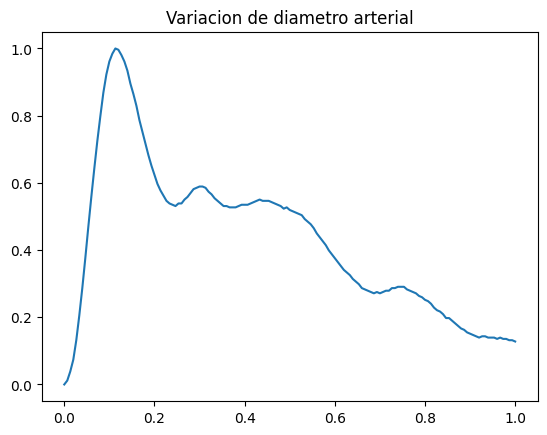

In [165]:


plt.plot(X11[:,1],X11[:,0])
plt.title("Variacion de diametro arterial")
plt.show()

In [190]:
my_sug_VDA = Sugeno(X11, cluster_alg="K", K=10)


In [191]:
my_sug_VDA.fit_clusters()

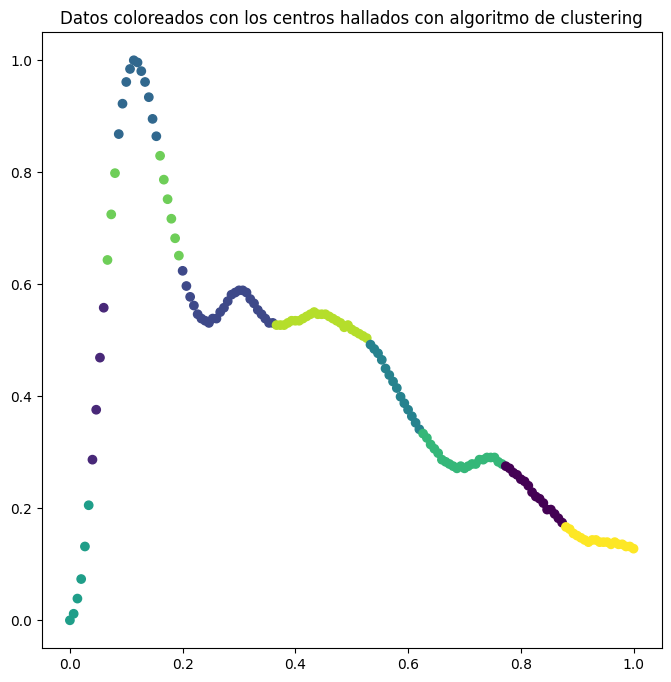

In [192]:
my_sug_VDA.plot_original_color_by_cluster()

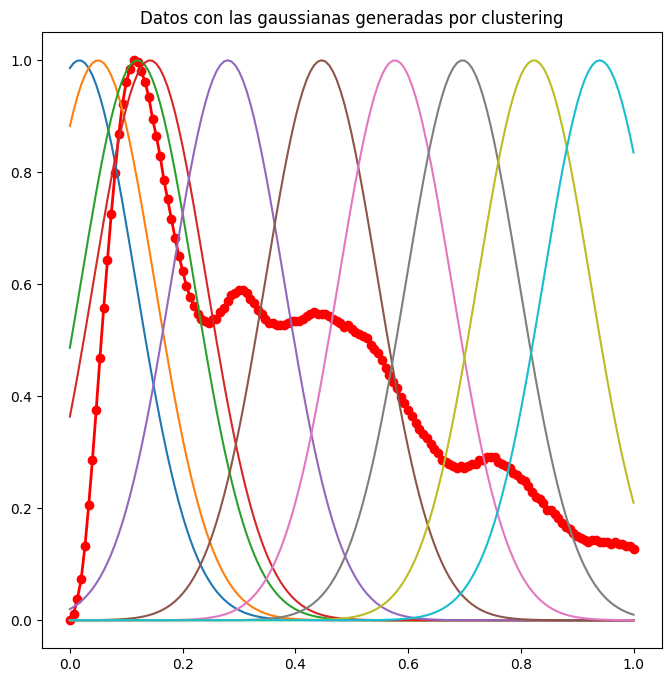

In [193]:
my_sug_VDA.plot_gaussians()

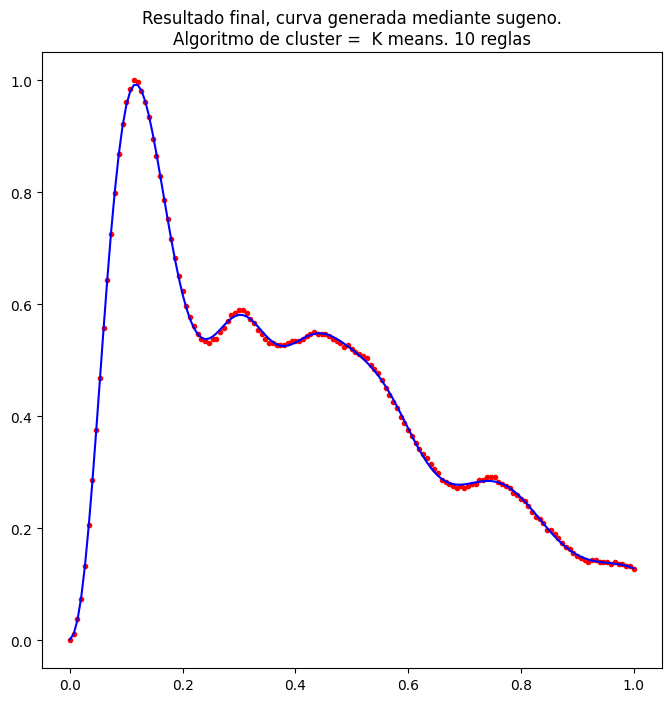

In [194]:
my_sug_VDA.get_sugeno_model_and_plot()

---
### Veamos que ocurre con clustering sustractivo

---

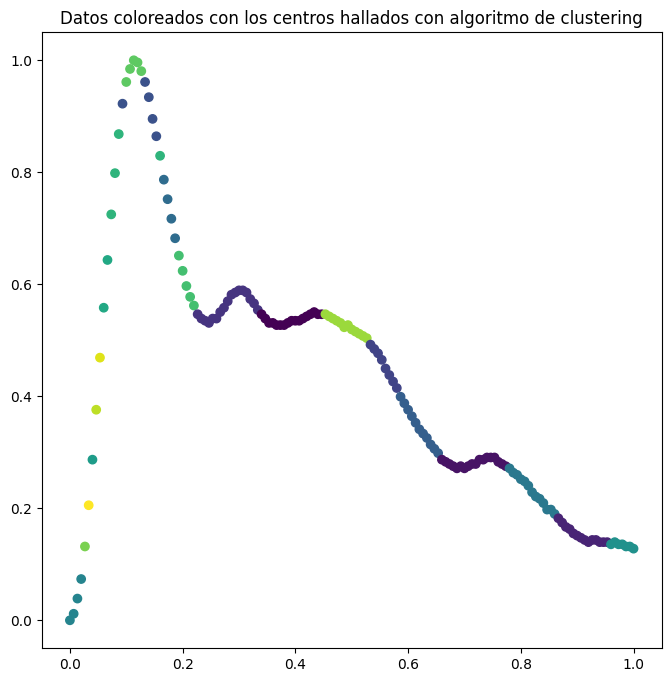

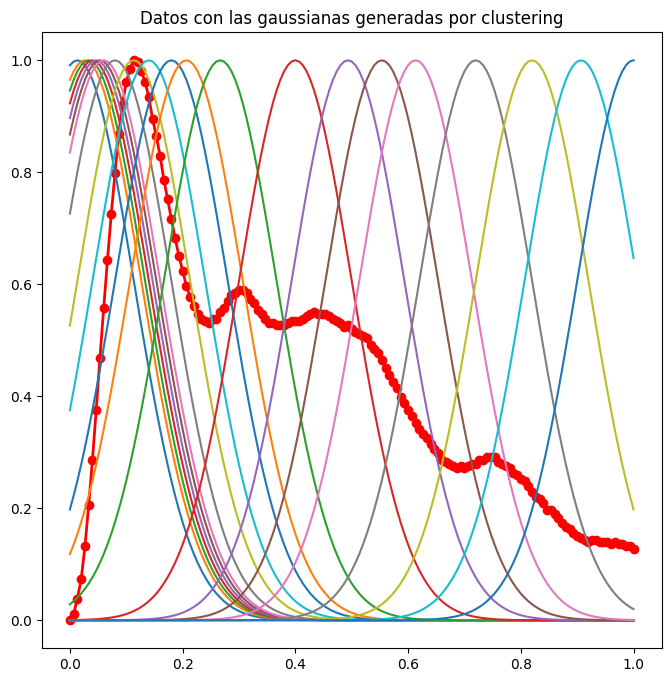

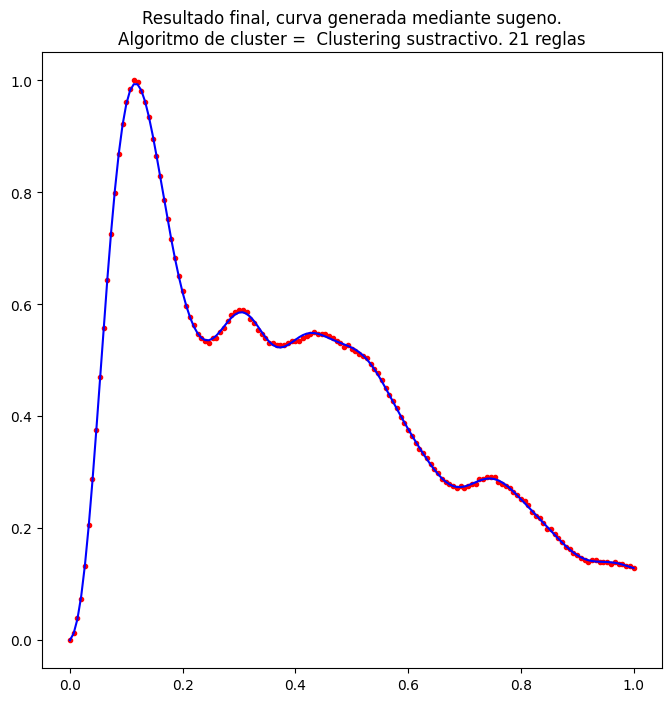

In [195]:
my_sug_VDA_CS = Sugeno(X11, cluster_alg="S", K=10, Ra=0.2, Rb=0.0, AcceptRatio=0.3, RejectRatio=0.1)
my_sug_VDA_CS.fit_clusters()
my_sug_VDA_CS.plot_original_color_by_cluster()
my_sug_VDA_CS.plot_gaussians()
my_sug_VDA_CS.get_sugeno_model_and_plot()